<a href="https://colab.research.google.com/github/Ilona019/ColabAlice/blob/main/%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%B8%D0%B4%D0%B5%D0%BD%D1%82%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D0%B2%D0%B7%D0%BB%D0%BE%D0%BC%D1%89%D0%B8%D0%BA%D0%B0_%D0%90%D1%80%D0%B5%D1%84%D1%8C%D0%B5%D0%B2%D0%B0_%D0%98%D0%BB%D0%BE%D0%BD%D0%B0_%D0%98%D0%92%D0%A2_21%D0%9C%D0%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Будем решать задачу идентификации взломщика по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

В этом соревновании будем решать похожую задачу: алгоритм будет анализировать последовательность из нескольких веб-сайтов, посещенных подряд одним и тем же человеком, и определять, Элис это или взломщик (кто-то другой).

Данные собраны с прокси-серверов Университета Блеза Паскаля. "A Tool for Classification of Sequential Data", авторы Giacomo Kahn, Yannick Loiseau и Olivier Raynaud.

**Задача – сделать прогнозы для сессий в тестовой выборке (test_sessions.csv), определить, принадлежат ли они Элис. Сделать посылку на kaggle.**


In [21]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')
#подключаю файл из папки Colab на Google диске
path_train_data = 'gdrive/My Drive/Colab_files/Catch_me/train_sessions.csv'
path_test_data = 'gdrive/My Drive/Colab_files/Catch_me/test_sessions.csv'
train_data = pd.read_csv(path_train_data)
test_data = pd.read_csv(path_test_data)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
print(train_data.head(n=10))
print(test_data.head(n=10))

   session_id  site1                time1  ...   site10               time10  target
0           1    718  2014-02-20 10:02:45  ...      NaN                  NaN       0
1           2    890  2014-02-22 11:19:50  ...   1518.0  2014-02-22 11:20:16       0
2           3  14769  2013-12-16 16:40:17  ...  14768.0  2013-12-16 16:40:24       0
3           4    782  2014-03-28 10:52:12  ...    782.0  2014-03-28 10:56:42       0
4           5     22  2014-02-28 10:53:05  ...    178.0  2014-02-28 10:57:11       0
5           6    570  2014-03-18 15:18:31  ...      NaN                  NaN       0
6           7    803  2014-02-13 16:45:35  ...  17514.0  2014-02-13 16:47:17       0
7           8     22  2013-04-12 10:27:26  ...  14421.0  2013-04-12 10:27:32       0
8           9    668  2014-03-17 16:23:08  ...     22.0  2014-03-17 16:23:53       0
9          10   3700  2014-02-20 16:09:13  ...   2044.0  2014-02-20 16:10:40       0

[10 rows x 22 columns]
   session_id  site1  ...   site10       

In [24]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19  si

In [25]:
sites_header = ['site%s' % i for i in range(1, 11)]
time_header = ['time%s' % i for i in range(1, 11)]
# Посмотрим на типы данных колонок
print(train_data.dtypes.value_counts())
print(test_data.dtypes.value_counts())
# Размерность DataFrame
print('Размерность train и test:', train_data.shape, test_data.shape,)
print(train_data['site1'].value_counts(dropna = False))

object     10
float64     9
int64       3
dtype: int64
object     10
float64     9
int64       2
dtype: int64
Размерность train и test: (253561, 22) (82797, 21)
21       13874
23        9244
782       7769
29        5501
22        5434
         ...  
40160        1
8884         1
17080        1
18402        1
19130        1
Name: site1, Length: 15765, dtype: int64


# **Предобработка**

In [26]:
# Заменим значения NA/NAN -> 0, преобразуем к int 
train_data[sites_header] = train_data[sites_header].fillna(0).astype('int')
test_data[sites_header] = test_data[sites_header].fillna(0).astype('int')

train_data[time_header] = train_data[time_header].fillna(0)
test_data[time_header] = test_data[time_header].fillna(0)
train_data[time_header]

# Дубликатов нет
print(train_data[train_data.duplicated() == True])
print(test_data[test_data.duplicated() == True])

Empty DataFrame
Columns: [session_id, site1, time1, site2, time2, site3, time3, site4, time4, site5, time5, site6, time6, site7, time7, site8, time8, site9, time9, site10, time10, target]
Index: []
Empty DataFrame
Columns: [session_id, site1, time1, site2, time2, site3, time3, site4, time4, site5, time5, site6, time6, site7, time7, site8, time8, site9, time9, site10, time10]
Index: []


In [27]:
 y_train = train_data['target'].values
 X_train = train_data.drop('target', axis=1)
 print(X_train)

        session_id  site1  ... site10               time10
0                1    718  ...      0                    0
1                2    890  ...   1518  2014-02-22 11:20:16
2                3  14769  ...  14768  2013-12-16 16:40:24
3                4    782  ...    782  2014-03-28 10:56:42
4                5     22  ...    178  2014-02-28 10:57:11
...            ...    ...  ...    ...                  ...
253556      253557   3474  ...    148  2013-11-25 10:27:53
253557      253558  12727  ...     21  2013-03-12 16:01:18
253558      253559   2661  ...      0                    0
253559      253560    812  ...    570  2013-12-19 15:20:24
253560      253561  34942  ...     33  2014-04-25 09:56:55

[253561 rows x 21 columns]


In [28]:
train_data[sites_header].to_csv('preprocessing_train_set_sites.txt', sep=' ', index=None, header=None);
test_data[sites_header].to_csv('preprocessing_test_set_sites.txt', sep=' ', index=None, header=None);
from sklearn.feature_extraction.text import CountVectorizer
count_vertorizer = CountVectorizer(ngram_range=(1, 3), max_features=50000)

In [29]:
train_sites = open('preprocessing_train_set_sites.txt')
test_sites = open('preprocessing_test_set_sites.txt')
X_train = count_vertorizer.fit_transform(train_sites)
X_test = count_vertorizer.transform(test_sites)
print(X_train.shape, X_test.shape)

(253561, 50000) (82797, 50000)


# **Логистическая регрессия**

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def calculate_quality_of_model(lr, X, y, split_ind):
  y_pred = lr.predict_proba(X[split_ind:, :])[:, 1]
  return roc_auc_score(y[split_ind:], y_pred)

lr = LogisticRegression(C=1.0, random_state=24, solver='saga', max_iter=500).fit(X_train, y_train)

print('100000 Score: ', calculate_quality_of_model(lr, X_train, y_train, 100000))
print('125000 Score: ', calculate_quality_of_model(lr, X_train, y_train, 125000))
print('200000 Score: ', calculate_quality_of_model(lr, X_train, y_train, 200000))

100000 Score:  0.9936167500325541
125000 Score:  0.9936152950480328
200000 Score:  0.9943896927790449


# Выделение новых признаков по времени посещения сайтов

In [31]:
# Датафрейм для записи новых признаков времени
spent_time_data = pd.DataFrame()

times = train_data[['time%s' % i for i in range(1, 11)]]
sites = train_data[['site%s' % i for i in range(1, 11)]].fillna(0).astype(int).values

for header_index in range(1, 10):
    spent_time_data['target'] = train_data['target']
    spent_time_data['time_diff{}'.format(header_index)] = (pd.to_datetime(times['time{}'.format(header_index + 1)]) - 
                        pd.to_datetime(times['time{}'.format(header_index)])).dt.total_seconds().fillna(0)

# Сумма по строкам датафрейма - время сессии
spent_time_data['session_time'] = np.sum(spent_time_data, axis=1)
# Выделим столбец для начала работы в интернете
spent_time_data['hour'] = pd.to_datetime(times['time1']).dt.hour
# Выделим столбец для определения дня недели
spent_time_data['day_of_week'] = pd.to_datetime(times['time1']).dt.weekday
# Выделим столбец для месяца
spent_time_data['month'] = pd.to_datetime(times['time1']).dt.month
# Посчитаем количество уникальных посещенных сайтов
spent_time_data['count_unique_sites'] = [len(np.unique(session[session != 0])) for session in sites]
print(spent_time_data.head())

   target    time_diff1  time_diff2  ...  day_of_week  month  count_unique_sites
0       0 -1.392891e+09         0.0  ...            3      2                   1
1       0  0.000000e+00         1.0  ...            5      2                   7
2       0  1.000000e+00         1.0  ...            0     12                   4
3       0  3.000000e+01        30.0  ...            4      3                   1
4       0  1.370000e+02         0.0  ...            4      2                   4

[5 rows x 15 columns]


Text(0.5, 1.0, 'Сессии Элис')

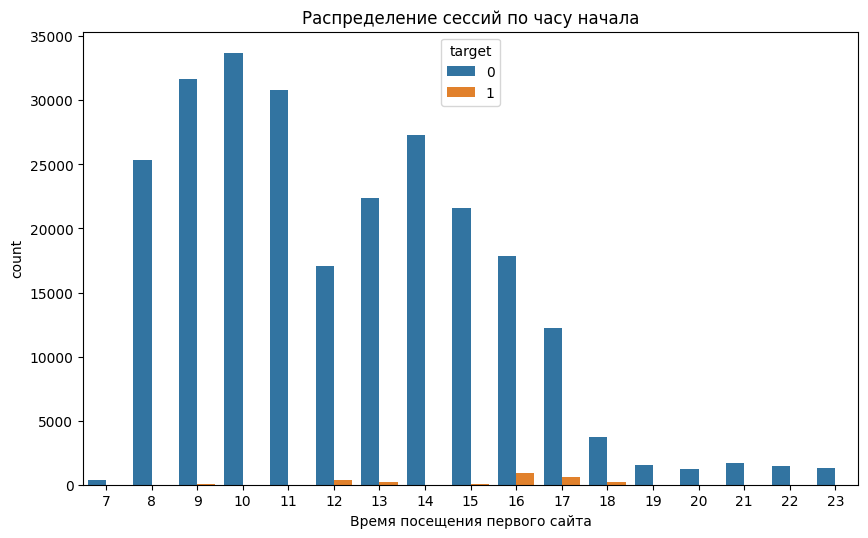

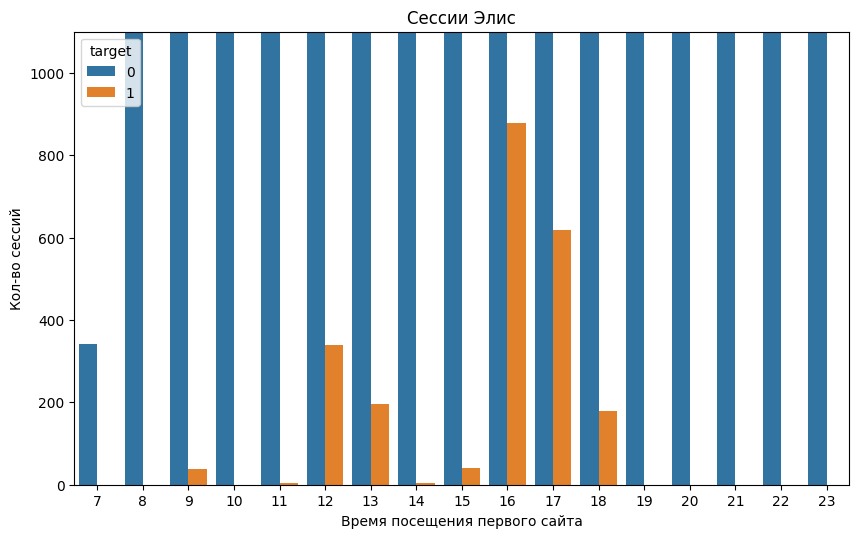

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6), dpi=100)
sns.countplot(x=spent_time_data['hour'], data=spent_time_data, hue='target')
plt.xlabel('Время посещения первого сайта')
plt.title('Распределение сессий по часу начала')

plt.figure(figsize=(10, 6), dpi=100)
plt.ylim(0, 1100)
sns.countplot(x=spent_time_data['hour'], data=spent_time_data, hue='target')
plt.ylabel('Кол-во сессий')
plt.xlabel('Время посещения первого сайта')
plt.title('Сессии Элис')

Активность Элис в интернете с 12 до 13 часов и с 16 до 18 часов. Изредка появлялась в 9 и 15 часов. 

Text(0.5, 1.0, 'Сессии Элис')

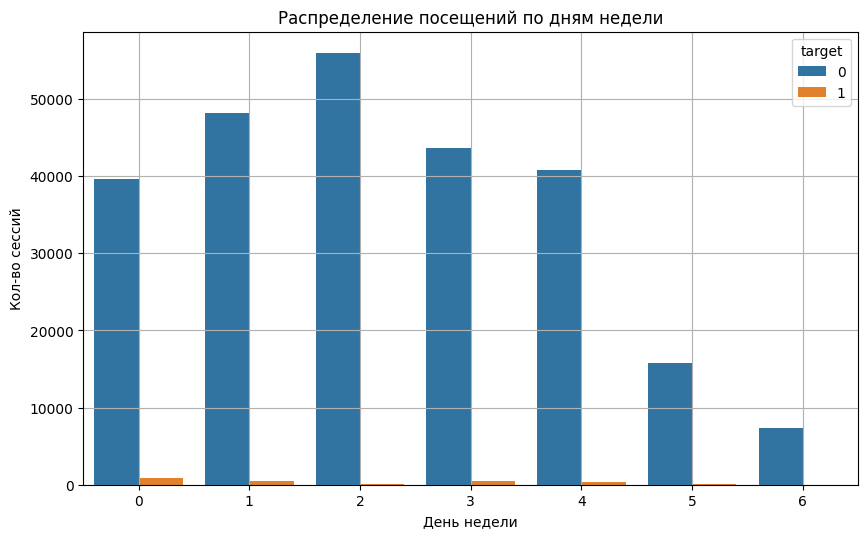

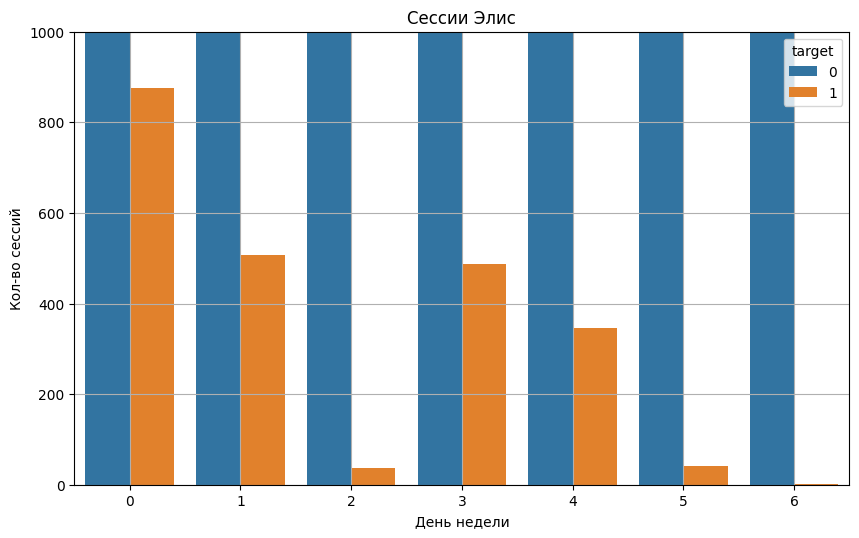

In [33]:
plt.figure(figsize=(10, 6), dpi=100)
sns.countplot(x=spent_time_data['day_of_week'], data=spent_time_data, hue='target')
plt.ylabel('Кол-во сессий')
plt.xlabel('День недели')
plt.grid()
plt.title('Распределение посещений по дням недели')

plt.figure(figsize=(10, 6), dpi=100)
plt.ylim(0, 1000)
sns.countplot(x=spent_time_data['day_of_week'], data=spent_time_data, hue='target')
plt.ylabel('Кол-во сессий')
plt.xlabel('День недели')
plt.grid()
plt.title('Сессии Элис')

Элис пользуется интернетом все дни, кроме вс. Небольшая активность в ср и сб.

Text(0.5, 1.0, 'Сессии Элис')

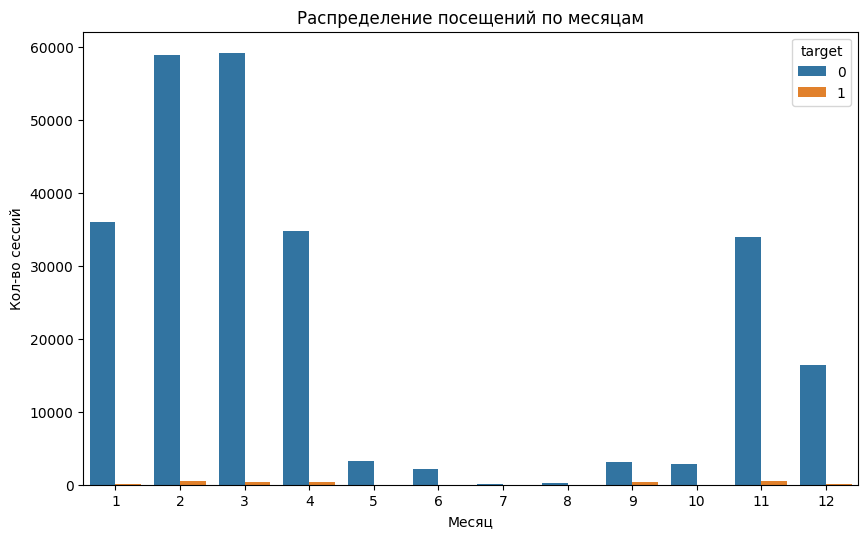

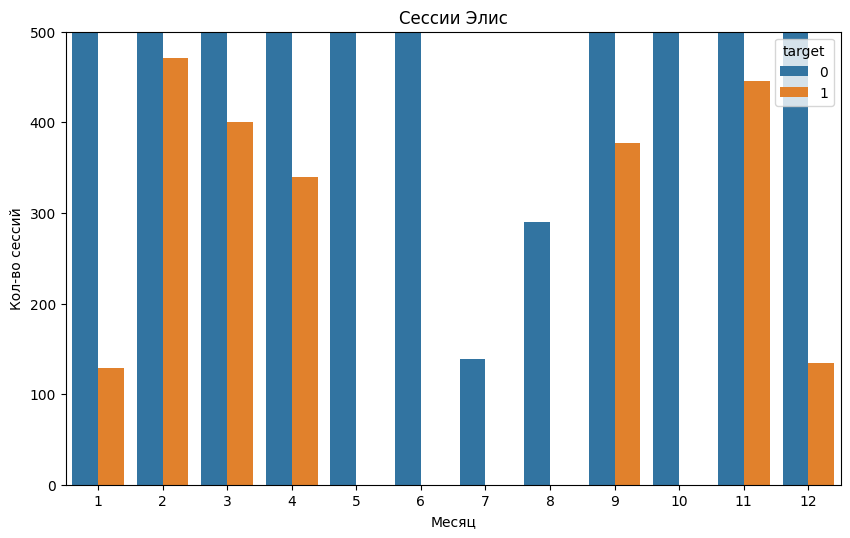

In [34]:
plt.figure(figsize=(10, 6), dpi=100)
sns.countplot(x=spent_time_data['month'], data=spent_time_data, hue='target')
plt.ylabel('Кол-во сессий')
plt.xlabel('Месяц')
plt.title('Распределение посещений по месяцам')

plt.figure(figsize=(10, 6), dpi=100)
plt.ylim(0, 500)
sns.countplot(x=spent_time_data['month'], data=spent_time_data, hue='target')
plt.ylabel('Кол-во сессий')
plt.xlabel('Месяц')
plt.title('Сессии Элис')

Наименьшая активность Элис с мая по август и в ноябре.

Text(0.5, 1.0, 'Сессии Элис')

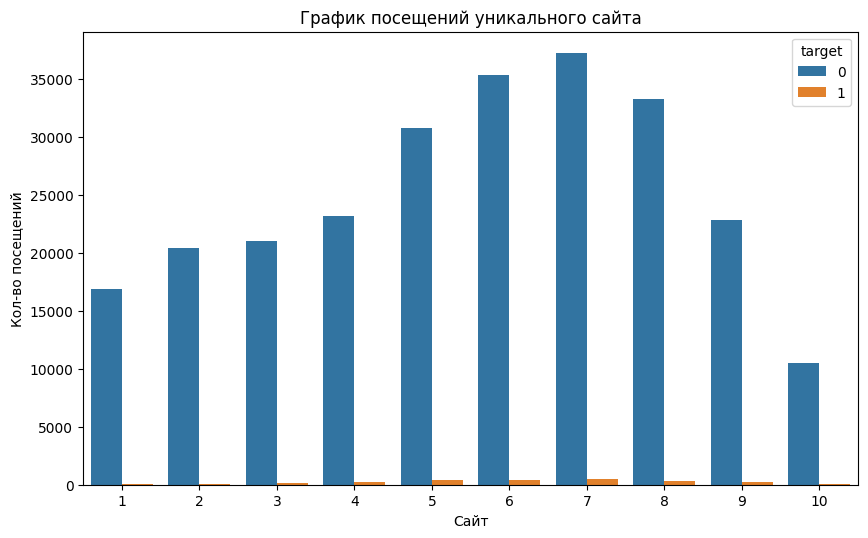

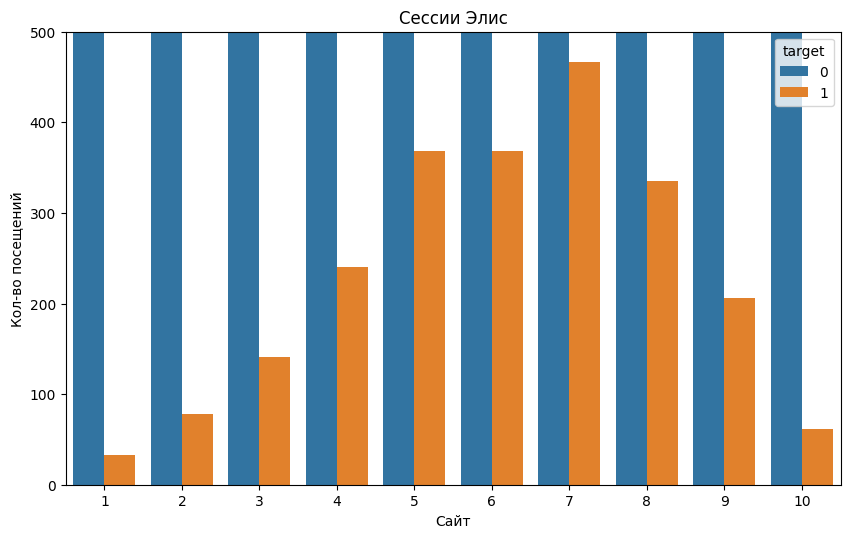

In [35]:
plt.figure(figsize=(10, 6), dpi=100)
sns.countplot(x=spent_time_data['count_unique_sites'], data=spent_time_data, hue='target')
plt.ylabel('Кол-во посещений')
plt.xlabel('Сайт')
plt.title('График посещений уникального сайта')

plt.figure(figsize=(10, 6), dpi=100)
plt.ylim(0, 500) 
sns.countplot(x=spent_time_data['count_unique_sites'], data=spent_time_data, hue='target')
plt.ylabel('Кол-во посещений')
plt.xlabel('Сайт')
plt.title('Сессии Элис') 

Элис посещает все теже сайты что и другие люди (злоумышленник).

Таким образом, есть смысл анализировать признаки:

*   время просмотра первого сайта
*   день недели
*   месяц

In [36]:
# Тестовая выборка с новыми признаками
test = pd.DataFrame()

time_test = test_data[['time%s' % i for i in range(1, 11)]]
sites_test = test_data[['site%s' % i for i in range(1, 11)]].fillna(0).astype(int).values

for header_index in range(1, 10):
    test['time_diff{}'.format(header_index)] = (pd.to_datetime(time_test['time{}'.format(header_index + 1)]) - 
                        pd.to_datetime(time_test['time{}'.format(header_index)])).dt.total_seconds().fillna(0)
   
test['session_time'] = np.sum(test, axis=1)
test['hour'] = pd.to_datetime(time_test['time1']).dt.hour
test['day_of_week'] = pd.to_datetime(time_test['time1']).dt.weekday
test['month'] = pd.to_datetime(time_test['time1']).dt.month
test['count_unique_sites'] = [len(np.unique(session[session != 0])) for session in sites_test]

print(test.head())

   time_diff1  time_diff2  time_diff3  ...  day_of_week  month  count_unique_sites
0         0.0         1.0         0.0  ...            5     10                  10
1        25.0         5.0         8.0  ...            3      7                   1
2         1.0         1.0        61.0  ...            4     12                   2
3         0.0         1.0         1.0  ...            1     11                   7
4         1.0         1.0         6.0  ...            4      5                   8

[5 rows x 14 columns]


In [37]:
# Сформируем колонки целевых признаков для новых данных
spent_time_data['target_hour'] = np.where(((spent_time_data['hour']>=12) & (spent_time_data['hour']<=13)) | ((spent_time_data['hour']>=16) & (spent_time_data['hour']<=18)), 0, 1)
test['target_hour'] = np.where(((test['hour']>=12) & (test['hour']<=13)) | ((test['hour']>=16) & (test['hour']<=18)), 1, 0)

spent_time_data['target_week_day'] = np.where((spent_time_data['day_of_week']==5) | (spent_time_data['day_of_week']==6), 1, 0)
test['target_week_day'] = np.where((test['day_of_week']==5) | (test['day_of_week']==6), 1, 0)

spent_time_data['target_month'] = np.where(((spent_time_data['month']>=5) & (spent_time_data['month']<=8)), 1, 0)
test['target_month'] = np.where(((test['month']>=5) & (test['month']<=8)), 1, 0)

target_train = spent_time_data[['target_hour', 'target_week_day','target_month']]
target_test = test[['target_hour', 'target_week_day','target_month']]

In [38]:
Y_train_spent_time = spent_time_data['target'].values
from sklearn.model_selection import train_test_split
X_train_log, X_valid_log, Y_train_log, Y_valid_log = train_test_split(X_train, Y_train_spent_time, test_size=0.1, random_state=24)
log_reg = LogisticRegression(C=1.0, random_state=24, solver='lbfgs', max_iter=500)
log_reg.fit(X_train_log, Y_train_log)

LogisticRegression(max_iter=500, random_state=24)

In [39]:
y_pred = log_reg.predict_proba(X_valid_log)
from sklearn.metrics import roc_auc_score
score_log = roc_auc_score(Y_valid_log, y_pred[:,1])
print("log",round(score_log, 2)*100)

log 96.0


In [40]:
log_reg.fit(X_train, Y_train_spent_time)
Y_test = log_reg.predict_proba(X_test)
Y_test[:5]

array([[9.98552672e-01, 1.44732836e-03],
       [9.99999980e-01, 1.95872065e-08],
       [9.99999952e-01, 4.84310610e-08],
       [9.99999887e-01, 1.13096850e-07],
       [9.99989614e-01, 1.03857771e-05]])

In [46]:
!pip install catboost
from catboost import CatBoostClassifier

In [59]:
SEED = 5
X_train, X_valid, y_train, Y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
params = {'loss_function':'Logloss',
          'eval_metric': 'AUC', 
          'verbose': 300,
          'random_seed': SEED
         }
cbc_1 = CatBoostClassifier(**params)
cbc_1.fit(X_train, y_train, 
          eval_set=(X_valid, Y_valid), 
          use_best_model=True, 
          plot=True 
         );

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.049375
0:	test: 0.5120664	best: 0.5120664 (0)	total: 75.3ms	remaining: 1m 15s
300:	test: 0.8596491	best: 0.8619777 (149)	total: 20.7s	remaining: 48s
600:	test: 0.8597947	best: 0.8619777 (149)	total: 41.8s	remaining: 27.7s
900:	test: 0.8821942	best: 0.8844831 (647)	total: 1m 3s	remaining: 7.02s
999:	test: 0.8822471	best: 0.8844831 (647)	total: 1m 11s	remaining: 0us

bestTest = 0.884483078
bestIteration = 647

Shrink model to first 648 iterations.


In [48]:
CatBoostClassifier?

# **Случайный лес**

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

parameters = {'max_features': [4, 10, 14], 'min_samples_leaf': [3, 5, 7], 'max_depth': [5, 10, 15, 20]}
rfc = RandomForestClassifier(n_estimators=50, random_state=24, 
                             n_jobs=8, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=8, cv=skf, verbose=1)
gcv.fit(X_train_log, Y_train_log)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=8,
                                              oob_score=True, random_state=24),
             n_jobs=8,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 10, 14],
                         'min_samples_leaf': [3, 5, 7]},
             verbose=1)

In [61]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(max_depth=5, max_features=4, min_samples_leaf=3,
                        n_estimators=50, n_jobs=8, oob_score=True,
                        random_state=24), 0.9907538868724384)

# Таким образом, лучше всего показала модель RandomForestClassifier
с точностью 0.9907538868724384 и параметрами:

*   max_depth=5
*   max_features=4
*   min_samples_leaf=3
*    n_estimators=50
*   n_jobs=8
*   oob_score=True

